# Análise de sentimentos em crítica de filmes

## Objetivo: saber se a crítica foi boa ou ruim

* fonte: https://www.kaggle.com/luisfredgs/imdb-ptbr

### Detalhes da fonte

 1. Originalmente foi feita em inglês e traduzida automaticamente para pt br, portanto podem ter erros na tradução
 2. Os dados já contém a resposta se a crítica foi boa ou não
 


In [1]:
import pandas as pd

df = pd.read_csv("C:/Users/samsung/Desktop/datasets/imdb/imdb-reviews-pt-br.csv")

In [2]:
df.head(3)

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg


In [3]:
# ok tem um tamanho bom de dados para analisar
df.shape

(49459, 4)

In [4]:
# vendo se tem dado nulo
df.isnull().sum()

id           0
text_en      0
text_pt      0
sentiment    0
dtype: int64

In [5]:
df.sentiment.value_counts() # ok tbm, os resultados têm uma boa proporção

neg    24765
pos    24694
Name: sentiment, dtype: int64

### Criando uma Base Line

In [6]:
# primeiro vou colocar a coluna sentment no padrão de resposta esperado

df["sentiment"] = df["sentiment"].replace(['neg','pos'],[0,1])
df.head(2)

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,0


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
# ficaaria muito custoso computacionalmente usar tudo
# peguei apenas as 100 palavras mais usadas

vetorizador = CountVectorizer(lowercase = False, max_features = 100) 
bag_of_words = vetorizador.fit_transform(df["text_pt"])

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bag_of_words, df.sentiment, test_size=0.33, random_state=42)

In [14]:
from sklearn.linear_model import LogisticRegression
reg_log = LogisticRegression()

reg_log.fit(x_train,y_train)
reg_log.score(x_test,y_test)

C:\Users\samsung\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7035902462933464

 ### Impressões 
 
 * Uma acurácia de 70% não é de se jogar fora e, dependendo do tipo de problema ou da regra de negócio, poderíamos ficar por aqui mesmo. Obviamente, não vamos fazer isso por se tratar de um exercício
 
 * Agora preciso colocar as palavras mais relevantes nas 100 usadas pelo countVectorizer

In [15]:
# criei essa função pra poder usar várias vezes

def classificar_texto(texto, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=100)
    bag_of_words = vetorizar.fit_transform(texto[coluna_texto])
    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                              texto[coluna_classificacao],
                                                              random_state = 42)
    regressao_logistica = LogisticRegression(solver = "lbfgs")
    regressao_logistica.fit(treino, classe_treino)
    return regressao_logistica.score(teste, classe_teste)

In [16]:
%matplotlib inline

from wordcloud import WordCloud
todas_as_palavras = ' '.join([texto for texto in df.text_pt]) # é a estrutura de dados que a wordcloud entende
len(todas_as_palavras)

63448424

In [17]:
nuvem_de_palavras = WordCloud(width = 800, height = 500,
                             max_font_size = 110,
                             collocations = False).generate(todas_as_palavras)

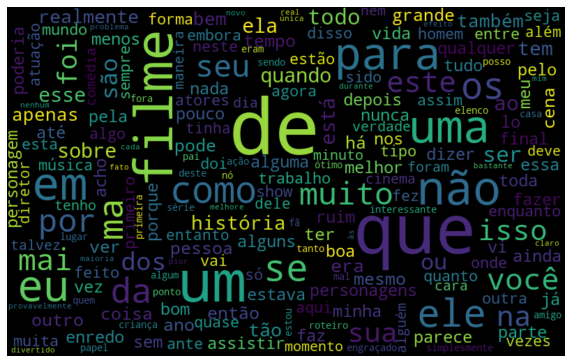

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
plt.imshow(nuvem_de_palavras,interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Observações

1. Separando em 2 nuvens, uma para os sentimentos positivos e outra pros negativos, vai ser possível ter novas ideias
2. Tem muitas stopwords, removê-las pode melhorar o modelo
3. As nuvens de palavras removem automaticamente as que tem apenas uma letra

#### Separando a nuvem de acordo com o sentimento

In [19]:
def gerador_nuvem(coluna,sentiment):
    query = 'sentiment == ' + str(sentiment)
    df_n = df.query(query)
    palavras_n = ' '.join([texto for texto in df_n[coluna]]) 
    nuvem_n = WordCloud(width = 800, height = 500,
                             max_font_size = 110,
                             collocations = False).generate(palavras_n)

    plt.figure(figsize = (10,7))
    plt.imshow(nuvem_n,interpolation = 'bilinear')
    plt.axis("off")
    plt.show()

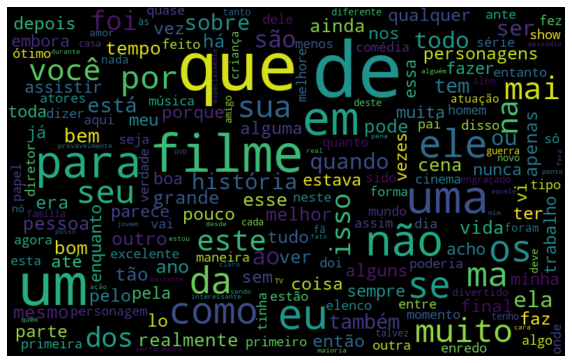

In [20]:
# sentimentos bons
gerador_nuvem('text_pt', 1)

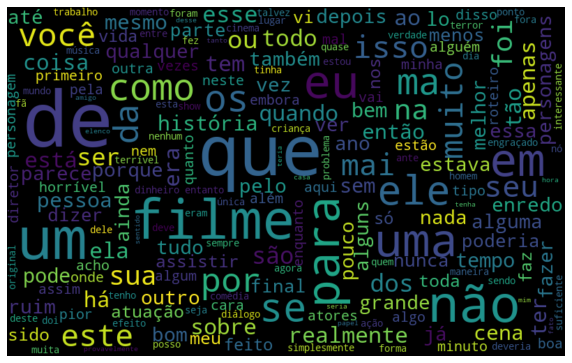

In [21]:
# Sentimentos ruins 
gerador_nuvem('text_pt', 0)

### Observações

1. Criar as nuvens de palavras por sentimento não foi de grande valia
2. Remover as stop words ainda é uma alternativa viável

#### Removendo as stop words:

In [22]:
import nltk
from nltk import tokenize

tokenizador = tokenize.WhitespaceTokenizer()

In [23]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("portuguese")

texto_processado = []
for critica in df.text_pt:
    palavras_relevantes = []
    critica_tokenizada = tokenizador.tokenize(critica)
    for palavra in critica_tokenizada:
        if palavra not in stop_words:
            palavras_relevantes.append(palavra)
    texto_processado.append(' '.join(palavras_relevantes))

df['text_stopwords'] = texto_processado
df.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samsung\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,text_en,text_pt,sentiment,text_stopwords
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",0,"Mais vez, Sr. Costner arrumou filme tempo nece..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,0,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",0,"Primeiro tudo odeio raps imbecis, poderiam agi..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,0,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,0,"Filmes fotos latão palavra apropriada eles, ve..."


In [24]:
classificar_texto(df,'text_stopwords', 'sentiment')

0.7096643752527295

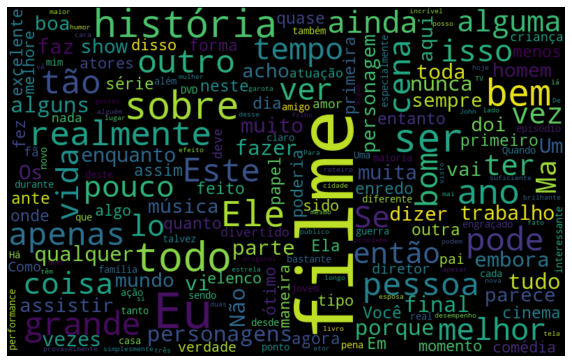

In [25]:
# positivo
gerador_nuvem('text_stopwords',1)

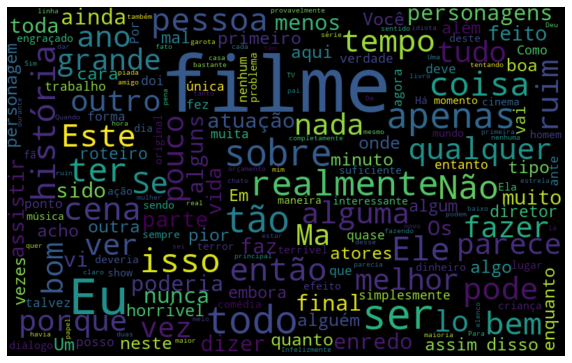

In [26]:
# negativo
gerador_nuvem('text_stopwords',0)

### Observações 

1. Esse tratamento inicial melhorou o modelo, mas não de forma significativa
2. Ainda temos muitas stop words para remover
3. Verificar se tem palavras não significativas com apenas uma letra e não classificada como stop words

In [27]:
import seaborn as sns
def pareto(df_n,coluna_texto,sentiment = 'all',num_bar = 10):
    
    if str(sentiment) == 'all':
        cor = 'grey'
    elif str(sentiment) == '1':
        cor = 'green'
    else:
        cor = 'red'
    
    if str(sentiment) != 'all':
        query = 'sentiment == ' + str(sentiment)
        df_n = df.query(query) 
    
    palavras = ' '.join([texto for texto in df_n[coluna_texto]])
    frequencia = nltk.FreqDist(tokenizador.tokenize(palavras))
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                             "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = num_bar)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x= "Palavra", y = "Frequência", color = cor)
    ax.set(ylabel = "Contagem")
    plt.show()
    

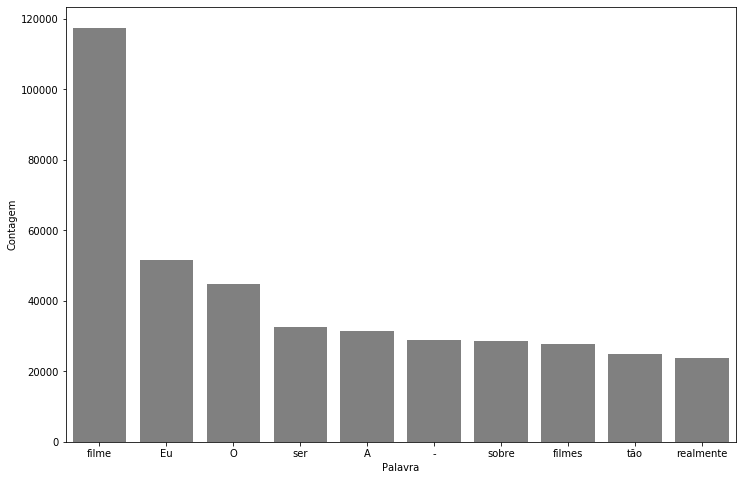

In [28]:
# mais usadas removendo stop words
pareto(df,'text_stopwords')

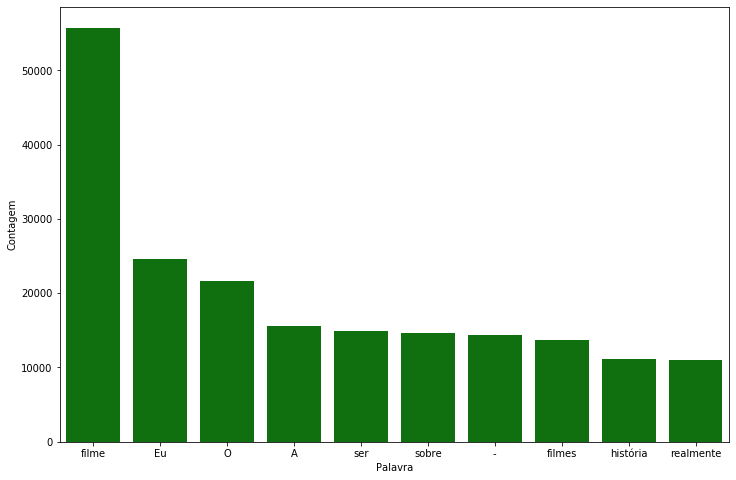

In [29]:
# mais usadas positivo
pareto(df,'text_stopwords', 1)

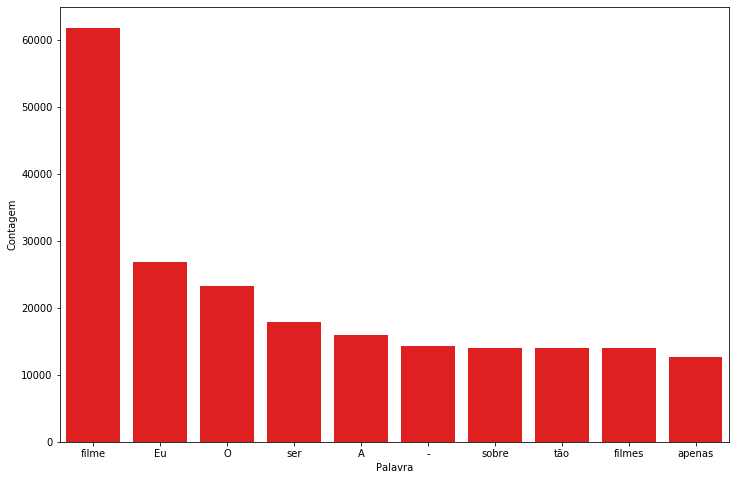

In [30]:
# mais usadas negativo
pareto(df,'text_stopwords', 0)

### Observações

1. As palavras nos 3 grupos nãos são mt diferentes e indicam muito pouco sobre o sentimento analisado
2. Ainda tem mts stop words pra remover
3. tem palavras com apenas uma letra para remover, isso não estava sendo indicado na wordcloud 
4. é estranho a string '-' ser tão usada, verificar as pontuações

In [31]:
from string import punctuation

pontuações = []
for ponto in punctuation:
    pontuações.append(ponto)

filtro = pontuações + stop_words

# separa as palavras considerando as pontuações
tokenizador_ponto = tokenize.WordPunctTokenizer()

texto_processado = []
for critica in df.text_stopwords:
    palavras_relevantes = []
    critica_tokenizada = tokenizador_ponto.tokenize(critica)
    for palavra in critica_tokenizada:
        if palavra not in filtro:
            palavras_relevantes.append(palavra)
    texto_processado.append(' '.join(palavras_relevantes))

df['text_stopwords_puctuation'] = texto_processado
df.head()

,id,text_en,text_pt,sentiment,text_stopwords,text_stopwords_puctuation
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",0,"Mais vez, Sr. Costner arrumou filme tempo nece...",Mais vez Sr Costner arrumou filme tempo necess...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,0,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",0,"Primeiro tudo odeio raps imbecis, poderiam agi...",Primeiro tudo odeio raps imbecis poderiam agir...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,0,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,0,"Filmes fotos latão palavra apropriada eles, ve...",Filmes fotos latão palavra apropriada verdade ...


In [32]:
classificar_texto(df,'text_stopwords_puctuation', 'sentiment')

0.7086130206227255

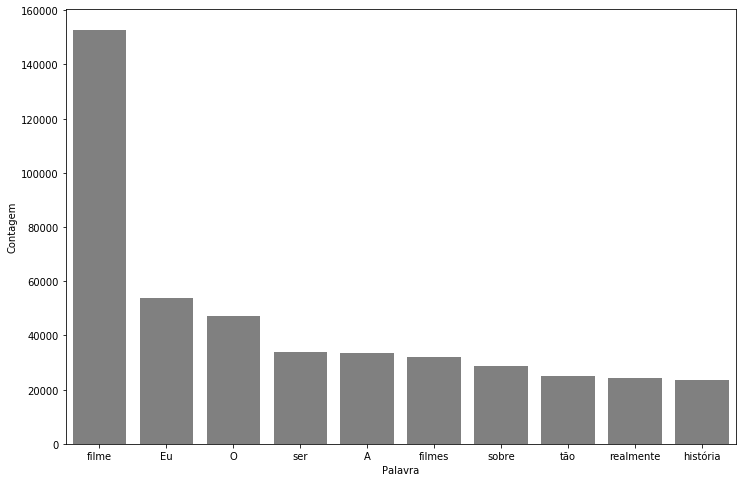

In [33]:
pareto(df,'text_stopwords_puctuation')

### Normalização de textos

In [38]:
import unidecode

In [36]:
# a ideia aqui é remover todos os acentos pra poder unir palavras iguais com grafias distintas e assim melhorar o modelo
# essa feature pode incluir ambiguidades no modelo -- Ver com cuidado

filtro = pontuações + stop_words
stopwords_sem_acento = [unidecode.unidecode(texto) for texto in filtro]

df["text_stopwords_semPontoEAcento"] = [unidecode.unidecode(texto) for texto in df["text_stopwords_puctuation"]]

In [37]:
texto_processado = list()
for critica in df.text_stopwords:
    critica = unidecode.unidecode(critica)
    palavras_relevantes = []
    critica_tokenizada = tokenizador_ponto.tokenize(critica)
    for palavra in critica_tokenizada:
        if palavra not in filtro:
            palavras_relevantes.append(palavra)
    texto_processado.append(' '.join(palavras_relevantes))

df['text_stopwords_semPontoEAcento'] = texto_processado
classificar_texto(df,'text_stopwords_semPontoEAcento', 'sentiment')

0.7087747674888799

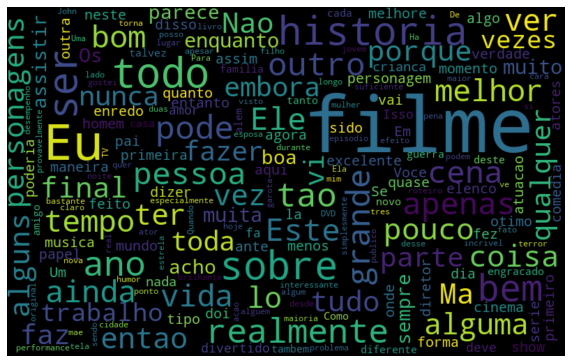

In [39]:
# positivo
gerador_nuvem('text_stopwords_semPontoEAcento',1)

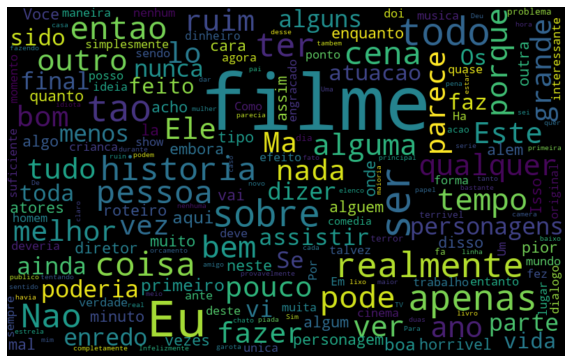

In [40]:
# negativo
gerador_nuvem('text_stopwords_semPontoEAcento',0)

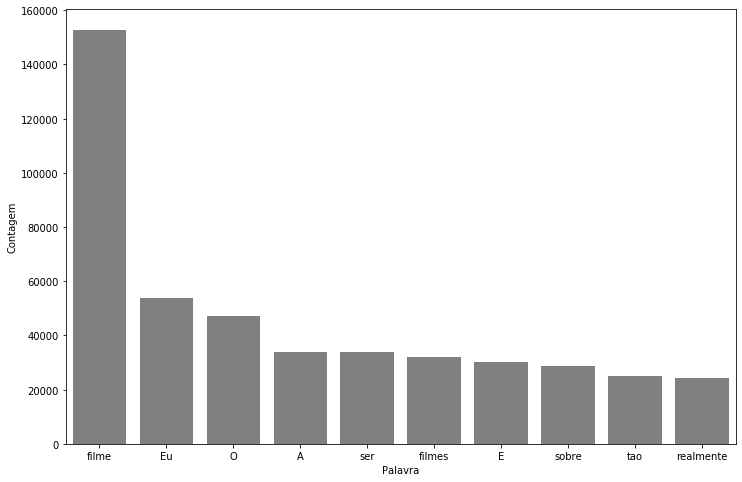

In [41]:
pareto(df,'text_stopwords_semPontoEAcento')

### transformando em minusculo

In [42]:
texto_processado = list()
for critica in df.text_stopwords_semPontoEAcento:
    critica = unidecode.unidecode(critica)
    critica = critica.lower()
    palavras_relevantes = []
    critica_tokenizada = tokenizador_ponto.tokenize(critica)
    for palavra in critica_tokenizada:
        if palavra not in filtro:
            palavras_relevantes.append(palavra)
    texto_processado.append(' '.join(palavras_relevantes))

df['text_stopwords_semPontoEAcento_minusculo'] = texto_processado
classificar_texto(df,'text_stopwords_semPontoEAcento_minusculo', 'sentiment')

0.7144359078042863

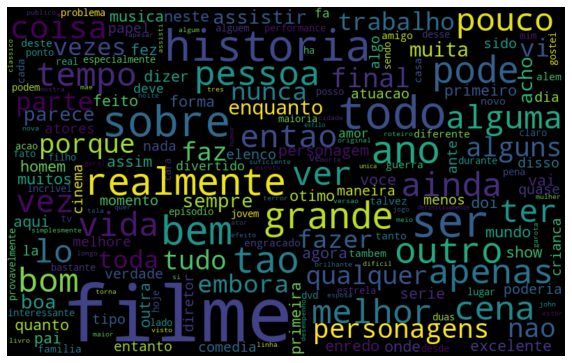

In [43]:
# positivo
gerador_nuvem('text_stopwords_semPontoEAcento_minusculo',1)

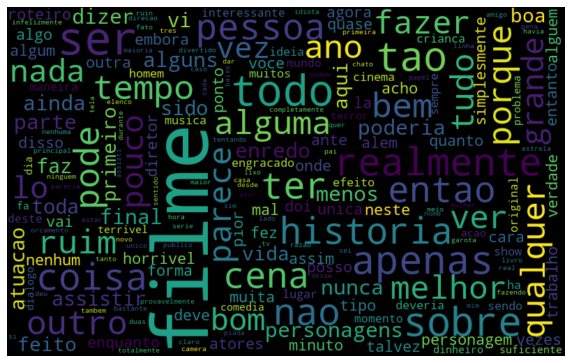

In [44]:
# neg
gerador_nuvem('text_stopwords_semPontoEAcento_minusculo',0)

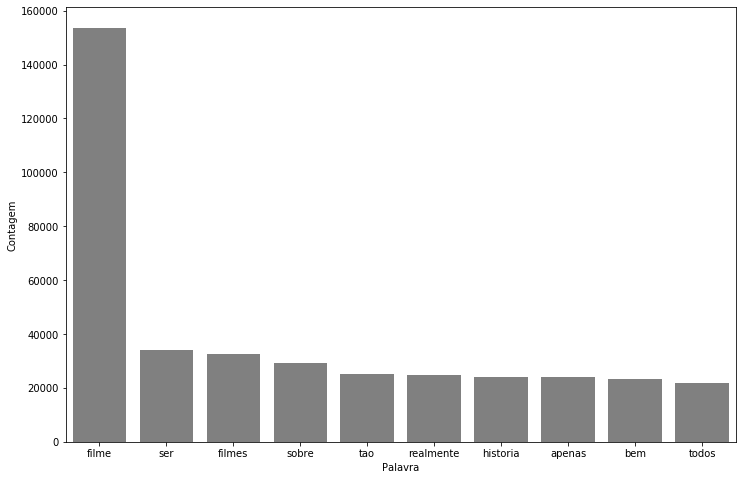

In [45]:
pareto(df,"text_stopwords_semPontoEAcento_minusculo")

### Observações

1. remover as letras maiúsculas melhorou significativamente o modelo, as palavras A E É foram incluídas nas stop words
2. uma alternativa é usar apenas os radicais das palavras

In [47]:
nltk.download('rslp')
stemmer = nltk.RSLPStemmer()

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\samsung\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping stemmers\rslp.zip.


In [48]:
texto_processado = list()
for critica in df.text_stopwords_semPontoEAcento_minusculo:
    palavras_relevantes = []
    critica_tokenizada = tokenizador_ponto.tokenize(critica)
    for palavra in critica_tokenizada:
        if palavra not in filtro:
            palavras_relevantes.append(stemmer.stem(palavra))
    texto_processado.append(' '.join(palavras_relevantes))

df['text_stopwords_semPontoEAcento_minusculo_stem'] = texto_processado
classificar_texto(df,'text_stopwords_semPontoEAcento_minusculo_stem', 'sentiment')

0.7456530529720987

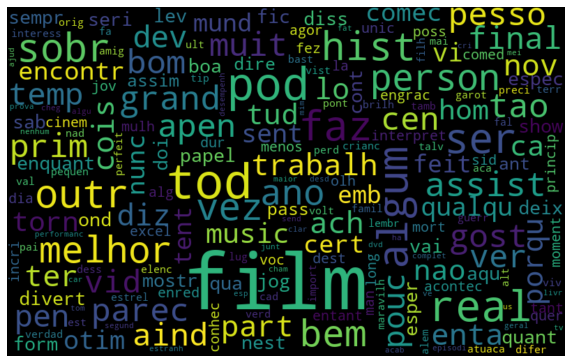

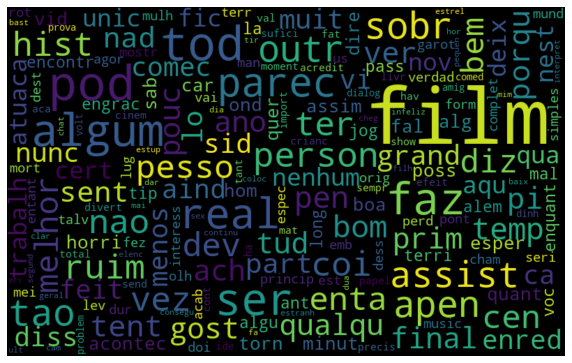

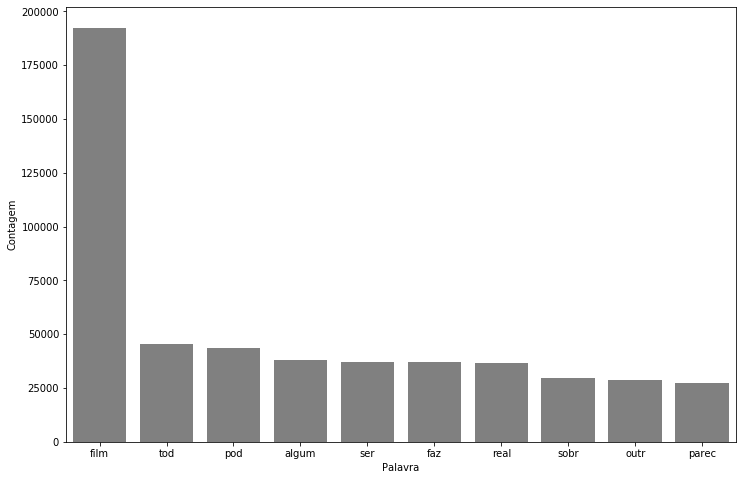

In [49]:
# positivo
gerador_nuvem('text_stopwords_semPontoEAcento_minusculo_stem',1)
# negativo
gerador_nuvem('text_stopwords_semPontoEAcento_minusculo_stem',0)

pareto(df,'text_stopwords_semPontoEAcento_minusculo_stem')